# Denoising Diffusion Probabilistic Models

In this notebook, we'll implement the Denoising Diffusion Probabilistic Model (DDPM) proposed in the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) from scratch using PyTorch. We'll implement the U-Net model, the forward and reverse diffusion processes, the training loop and the sampling process.

In [54]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import pickle
import numpy as np

from src.utils import show_torch_image

## UNet
At the heart of DDPMs is the U-Net model. The U-Net is a symmetrical architecture with an encoder (left) and decoder (right) path. It takes in a noisy image and predicts the amount of noise that was added to it. 

In the denoising process, the U-Net takes in the noisy image and the timestep and predicts the amount of noise that was added to it. We can then use this prediction to denoise the image by subtracting the predicted noise from the noisy image. In this manner, we gradually transform the noisy image to a clear image. 

We split the U-net into 3 blocks, Left, Middle and Right.

At the root of it all is the conv block. Each layer in the left and the right blocks consists of a series of ConvBlocks followed by a maxpool or an upsample. 

The convblocks are resnets with group normalization and are imported from src.resnet.py. We changed the original resnets to accept "timestep embeddings" that we'll explore later. 


### Changes that need to be made to a regular [U-Net](https://arxiv.org/abs/1505.04597) for DDPM:


1. Swap batch norm with group norm 
2. Introduce an attention mechanism at each conv block in the down and up blocks
3. Create an embedding for the timestep
4. Develop a 2D attention mechanism based on the one used in the text transformer model in [aryamanpandya99/transformers](https://github.com/aryamanpandya99/transformers)


## ConvBlock Illustrated

The ConvBlock is a resnet with group normalization followed by a 2D multihead attention. We can set the number of resblocks in the ConvBlock as a parameter. 

# <img src="images/convblock.png" alt="ConvBlock Illustrated" width="50%"/>


In [55]:
from src.resnet import ResBlock


class ConvBlock(nn.Module):
    def __init__(
            self, 
            in_channels: int, 
            out_channels: int, 
            num_layers: int, 
            num_groups: int = 1, 
            dropout: float = 0.2, 
            activation: nn.Module = nn.ReLU,
            timestep_emb_dim: int = None
            ):
        super(ConvBlock, self).__init__()
        convs = []
        convs.append(
            ResBlock(
                in_channels, 
                out_channels, 
                num_groups=num_groups, 
                dropout=dropout, 
                activation=activation,
                timestep_emb_dim=timestep_emb_dim
            )
        )
        
        for _ in range(num_layers-1):
            convs.append(
                ResBlock(
                    out_channels,
                    out_channels, 
                    num_groups=num_groups, 
                    dropout=dropout, 
                    activation=activation,
                    timestep_emb_dim=timestep_emb_dim
                )
            )

        self.convs = nn.ModuleList(convs)

    def forward(self, x, timestep_emb=None):
        for res_block in self.convs:
            x = res_block(x, timestep_emb)
        
        return x

## Changes to the attention mechanism from Attention is all you need

- we no longer need a d_model, the internal hidden size is determined by the number of channels which is determined by the convolutional layers leading up to the attention layer.

- swap batch norm with group norm

- we resize the image to one of shape: (batch_size, num_channels, height * width) so that we can perform multihead attention across the image. This closely mirrors (batch_size, embed_dim, seq_len)


In [56]:
def scaled_dot_product_attention(q, k, d_k, mask):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is True:
        mask = torch.tril(torch.ones(scores.shape)).to(q.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))
    return nn.Softmax(-1)(scores)

class Attention(nn.Module):
    """
    Multihead attention.
    """
    def __init__(self,
                 d_k: int, 
                 dropout: float, 
                 num_heads: int, 
                 num_channels: int,
                 num_groups: int = 8,
                 mask: bool = False
                 ):
        super(Attention, self).__init__()
        self.d_k, self.num_heads = d_k, num_heads
        self.query_projection, self.key_projection, self.value_projection = (
            nn.Linear(num_channels, num_heads* d_k),
            nn.Linear(num_channels, num_heads* d_k), 
            nn.Linear(num_channels, num_heads*d_k)
        )
        self.layer_norm = nn.LayerNorm(num_channels)
        self.output_layer = nn.Linear(num_heads*d_k, num_channels)
        self.dropout = nn.Dropout(dropout)
        self.mask = mask
        self.num_channels = num_channels

    def forward(self, x, y = None):
        
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, height * width).permute(0, 2, 1)
        residual = x
        x = self.layer_norm(x)
        
        if y is not None:
            k, q, v = y, x, y
        else:
            k, q, v = x, x, x
        
        k_len, q_len, v_len, batch_size = k.size(1), q.size(1), v.size(1),  q.size(0)
        
        k = self.key_projection(k).view(batch_size, k_len,  self.num_heads, self.d_k)
        q = self.query_projection(q).view(batch_size, q_len,  self.num_heads, self.d_k)
        v = self.value_projection(v).view(batch_size, v_len,  self.num_heads, self.d_k)
        
        attention = scaled_dot_product_attention(
            q.transpose(1, 2), 
            k.transpose(1, 2), 
            self.d_k, 
            self.mask
        )
        output = torch.matmul(attention, v.transpose(1, 2))
        output = self.output_layer(output.transpose(1, 2).contiguous().view(batch_size, q_len, -1))

        h = self.dropout(output) + residual

        h = h.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        
        return h


In [57]:
example_image = torch.randn(2, 3, 128, 128)
conv_block = ConvBlock(3, 32, 2)
h_example_image = conv_block(example_image)

In [58]:
attention_block = Attention(d_k=64, dropout=0.1, num_heads=3, num_channels=32, num_groups=8)
attn_output = attention_block(h_example_image)
attn_output.shape

torch.Size([2, 32, 128, 128])

# Timestep Encoding and Embedding

TODO: Explain

In [59]:
def timestep_encoding(curr_t: torch.Tensor, T: torch.Tensor, embedding_dim: int, n=10000, device: torch.device = "cpu"):
    """
    Naive sin/cosin positional embedding adapted for timestep embedding in DDPM
    """
    curr_t = curr_t / T # normalize the timestep to be between 0 and 1
    p = torch.zeros((curr_t.shape[-1], embedding_dim)).to(device) # initialize the positional embedding tensor

    m = torch.arange(int(embedding_dim/2)).to(device) # this is divided by two because we alternate between sin and cos
    denominators = torch.pow(n, (2*m/embedding_dim))  # compute the denominators for the sin and cos functions
    
    p[:, 0::2] = torch.sin(curr_t.unsqueeze(1) / denominators.unsqueeze(0))
    p[:, 1::2] = torch.cos(curr_t.unsqueeze(1) / denominators.unsqueeze(0))
    return p



class TimestepEmbedding(nn.Module):
    """
    Embeds the timestep into a higher dimensional space using a 2 layer MLP.
    """
    def __init__(self,
                in_channels: int, 
                embedding_dim: int, 
                activation: nn.Module = nn.ReLU
                ):
        """
        Args:
            in_channels: number of input channels
            embedding_dim: dimension of the embedding space
            activation: activation function
        """
        super(TimestepEmbedding, self).__init__()
        self.linear1 = nn.Linear(in_channels, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim)
        self.activation = activation()

    def forward(self, curr_t: torch.Tensor, T: torch.Tensor):
        x = self.linear1(curr_t)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        
        return x

## UNet Illustrated

I found that there weren't too many good illustrations of the specific UNet architecture used in DDPMs, so I decided to make my own. Hopefully this helps someone understand how UNets are implemented for diffusion, or at least understand my specific implementation better. 

This UNet is built off of the ConvBlocks and the TimestepEmbedding that we defined earlier. 

# <img src="images/ddpm_unet_illustrated.png" alt="UNet Illustrated" width="50%"/>



In [60]:
class LeftBlock(nn.Module):
    """
    Downampling (left) side of the UNet.
    Excludes the bottom-most conv block.
    """
    def __init__(
            self, 
            in_channels: int, 
            filters: list[int], 
            num_layers: int, 
            has_attention: list[bool] = [False, True, False], 
            num_heads: int = 8, 
            dropout: float = 0.2, 
            timestep_emb_dim: int = None
            ):
        super(LeftBlock, self).__init__()
        
        self.has_attention = has_attention
        conv_blocks = [ConvBlock(in_channels, filters[0], num_layers, timestep_emb_dim=timestep_emb_dim)]
        attention_blocks = [
            Attention(
                d_k=64, 
                dropout=0.1, 
                num_heads=num_heads, 
                num_channels=filters[0], 
            )
        ] if has_attention else []
        
        for i in range(1, len(filters)):
            conv_blocks.append(ConvBlock(filters[i-1], filters[i], num_layers, timestep_emb_dim=timestep_emb_dim))
            if has_attention[i]:
                attention_blocks.append(
                    Attention(
                        d_k=64, 
                        dropout=dropout, 
                        num_heads=num_heads, 
                        num_channels=filters[i], 
                    )
                )
            else:
                attention_blocks.append(None)
        
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.attention_blocks = nn.ModuleList(attention_blocks)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x, timestep_emb=None):
        residual_outputs = []
        for i, conv_block in enumerate(self.conv_blocks):
            x = conv_block(x, timestep_emb)
            if self.has_attention[i]:
                x = self.attention_blocks[i](x)
            
            residual_outputs.append(x)
            x = self.maxpool(x)

        return residual_outputs, x


class RightBlock(nn.Module):
    """
    Upsampling (right) side of the UNet.
    """
    def __init__(
            self, 
            filters: list[int], 
            num_layers: int, 
            has_attention: list[bool] = [False, True, False], 
            num_heads: int = 8, 
            dropout: float = 0.2,
            timestep_emb_dim: int = None,
            ):
        super(RightBlock, self).__init__()
        self.has_attention = has_attention

        conv_layers = []
        upsample_layers = []
        attention_layers = []
        
        for i in range(len(filters) - 2):
            conv_layers.append(
                ConvBlock(filters[i], filters[i+1], num_layers, timestep_emb_dim=timestep_emb_dim)
            )
            upsample_layers.append(
                nn.ConvTranspose2d(filters[i+1], filters[i+1]//2, 2, stride=2)
            )

            if has_attention[i]:
                attention_layers.append(
                    Attention(d_k=64, dropout=0.1, num_heads=num_heads, num_channels=filters[i+1]//2)
                )
            else:
                attention_layers.append(None)
        
        conv_layers.append(
            ConvBlock(filters[-2], filters[-1], num_layers, timestep_emb_dim=timestep_emb_dim)
        )

        self.conv_layers = nn.ModuleList(conv_layers)
        self.attention_layers = nn.ModuleList(attention_layers)
        self.upsample_layers = nn.ModuleList(upsample_layers)
    
    def forward(self, x, residual_outputs, timestep_emb=None):
        for i in range(len(self.conv_layers)):
            residual = residual_outputs[-(i+1)]
            _, _, h, w = x.shape
            residual = residual[:, :, :h, :w]

            x = torch.cat([x, residual], dim=1)
            x = self.conv_layers[i](x, timestep_emb)

            if i < len(self.upsample_layers):
                x = self.upsample_layers[i](x)

                if self.has_attention[i]:
                    x = self.attention_layers[i](x)
        
        return x


In [61]:
db = LeftBlock(in_channels=3, filters=[32, 64, 128], num_layers=2, has_attention=[True, True, False], num_heads=3, timestep_emb_dim=128)

In [62]:
timesteps = torch.randint(0, 1000, (2,))
t_encoded = timestep_encoding(timesteps, 1000, 32)
t_encoded.shape # N x 32

time_embedding_layer = TimestepEmbedding(in_channels=32, embedding_dim=128, activation=nn.ReLU) # N x 32 -> N x 128 (embedding_dim)
t_embedded = time_embedding_layer(curr_t=t_encoded, T=1000)

In [63]:
a = db(torch.randn(2, 3, 128, 128), timestep_emb=t_embedded)
a[1].shape

torch.Size([2, 128, 16, 16])

In [64]:
for residual_output in a[0]:
    print(residual_output.shape)
    print("-"*10)

print(a[1].shape)

torch.Size([2, 32, 128, 128])
----------
torch.Size([2, 64, 64, 64])
----------
torch.Size([2, 128, 32, 32])
----------
torch.Size([2, 128, 16, 16])


In [65]:
bottom_conv = nn.Sequential(ResBlock(128, 256), nn.ConvTranspose2d(256, 128, 2, stride=2))
bottom_conv(a[1]).shape

torch.Size([2, 128, 32, 32])

In [66]:
up = RightBlock(filters=[256, 128, 64, 32], num_layers=2, has_attention=[True, True, False, False], num_heads=3, timestep_emb_dim=128)

In [67]:
bottom_out = bottom_conv(a[1])
bottom_out.shape


torch.Size([2, 128, 32, 32])

In [68]:
up_out = up(bottom_out, a[0], t_embedded)
up_out.shape

torch.Size([2, 32, 128, 128])

In [69]:
class UNet(nn.Module):
    """
    UNet model for DDPM.
    """
    def __init__(self,
                 down_filters: list[int], 
                 in_channels: int, 
                 num_layers: int, 
                 has_attention: list[bool] = [False, True, False], 
                 num_heads: int = 8,
                 diffusion_steps: int = None,
                 num_groups: int = 8,
                 activation: nn.Module = nn.ReLU,
                ):
        super(UNet, self).__init__()
        self.T = diffusion_steps
        self.down_filters = down_filters
        self.num_groups = num_groups
        self.activation = activation()

        self.time_embed_dim = down_filters[0] * 4 
        
        if self.T is not None:
            self.timestep_embedding = TimestepEmbedding(
                in_channels=self.down_filters[0], 
                embedding_dim=self.time_embed_dim, 
                activation=activation, 
            )
        
        
        self.left_block = LeftBlock(
            filters=down_filters, 
            num_layers=num_layers, 
            in_channels=in_channels, 
            has_attention=has_attention, 
            num_heads=num_heads,
            timestep_emb_dim=self.time_embed_dim  # Add this line
        )
        
        # the bottom-most (middle) conv block 

        self.middle_conv = ConvBlock(
            down_filters[-1], 
            down_filters[-1]*2, 
            num_layers, 
            timestep_emb_dim=self.time_embed_dim  # Change this line
        )
        self.middle_attention = Attention(d_k=64, dropout=0.1, num_heads=num_heads, num_channels=down_filters[-1]*2)
        self.middle_upsample = nn.ConvTranspose2d(down_filters[-1]*2, down_filters[-1], 2, stride=2)
        
        
        self.up_filters = [down_filters[-1]*2]
        self.up_filters.extend(reversed(down_filters))
        self.right_block = RightBlock(
            filters=self.up_filters, 
            num_layers=num_layers, 
            has_attention=has_attention, 
            num_heads=num_heads,
            timestep_emb_dim=self.time_embed_dim  # Change this line
        )
        
        first_group = num_groups if in_channels > num_groups else in_channels
        self.group_norm = nn.GroupNorm(num_groups=first_group, num_channels=in_channels)  # Change this line

        self.group_norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=down_filters[0])
        
        self.conv_out = nn.Conv2d(in_channels=down_filters[0], out_channels=in_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        if self.T is not None:
            t_encoded = timestep_encoding(t, self.T, self.down_filters[0], n = 4000, device=x.device)
            t_emb = self.timestep_embedding(curr_t=t_encoded, T=self.T)
            
            t_emb = t_emb.view(-1, self.time_embed_dim)
        else: 
            t_emb = None

        h = self.group_norm(x)
        
        res, h = self.left_block(h, t_emb)
        
        h = self.middle_conv(h, t_emb)
        h = self.middle_attention(h)
        h = self.middle_upsample(h)

        h = self.right_block(h, res, t_emb)
        
        h = self.activation(self.group_norm2(h))

        output = self.conv_out(h)
        return output


In [70]:
u_net = UNet(down_filters=[32, 64, 128], in_channels=3, num_layers=2, has_attention=[True, True, False], num_heads=3, diffusion_steps=1000)


In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(u_net)
print(f"The UNet model has {num_params:,} trainable parameters.")


The UNet model has 4,524,751 trainable parameters.


In [72]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

sample_inputs = torch.randn(16, 3, 32, 32).to(device)
u_net.to(device)
sample_outputs = u_net(sample_inputs, torch.randint(0, 1000, (16,)).to(device))
sample_outputs.shape

torch.Size([16, 3, 32, 32])

## Training and Validation

In [73]:
def get_alpha_bar(beta_schedule: torch.Tensor):
    """
    what we need to do here is prepare a tensor of alpha_bars where each t'th entry
    in alphabars is the product of the alphas leading up to it. Alpha is  as 1 - beta
    """
    alpha = 1. - beta_schedule
    return alpha.cumprod(dim=0)

def prepare_batch(x: torch.Tensor, T: int, alpha_bar: torch.Tensor):
    """
    Prepare a batch for training by generating random timesteps and adding noise to the image.
    We use the random timesteps to generate the amount of noise that should be added to the image at that timestep.
    Then, we add the noise to the image.
    
    Args:
        x: the input image
        T: the number of diffusion steps
        beta_schedule: the beta values for each timestep
    
    Returns:
        the noisy image and the timestep 
        the noise that was added to the image
    """
    t = torch.randint(0, T, (x.shape[0],), requires_grad=False).to(x.device)
    e = torch.randn_like(x, requires_grad=False).to(x.device)
    
    alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
    noisy_images = (alpha_bar_t.sqrt() * x) + ((1 - alpha_bar_t).sqrt() * e)
    
    return (noisy_images, t), e

In [74]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.1307,), (0.3081,)),  # MNIST normalization
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# Move data to device
train_dl = [(x.to(device), y.to(device)) for x, y in train_dl]
valid_dl = [(x.to(device), y.to(device)) for x, y in valid_dl]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Number of batches in train_dl: {len(train_dl)}")
print(f"Number of batches in valid_dl: {len(valid_dl)}")

Train dataset size: 60000
Validation dataset size: 10000
Number of batches in train_dl: 469
Number of batches in valid_dl: 79


torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])
torch.Size([128])
torch.Size([128, 1, 32, 32])


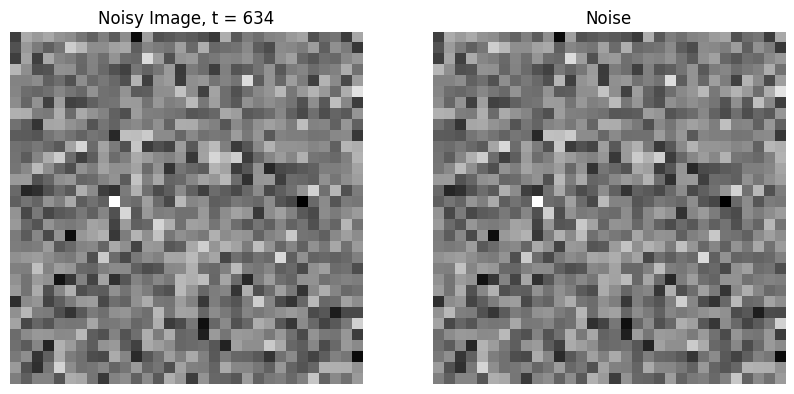

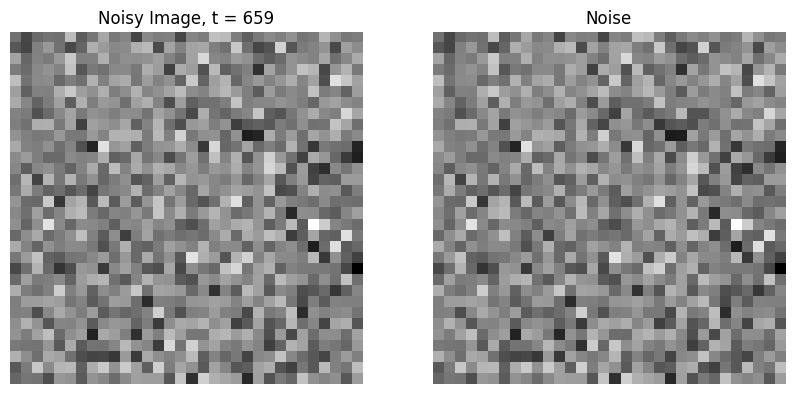

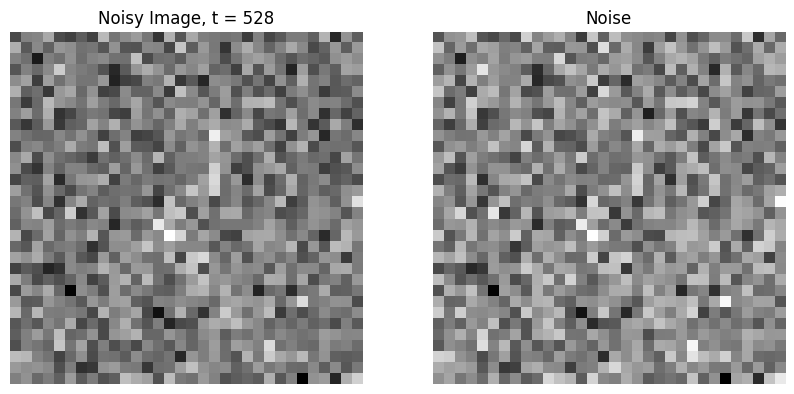

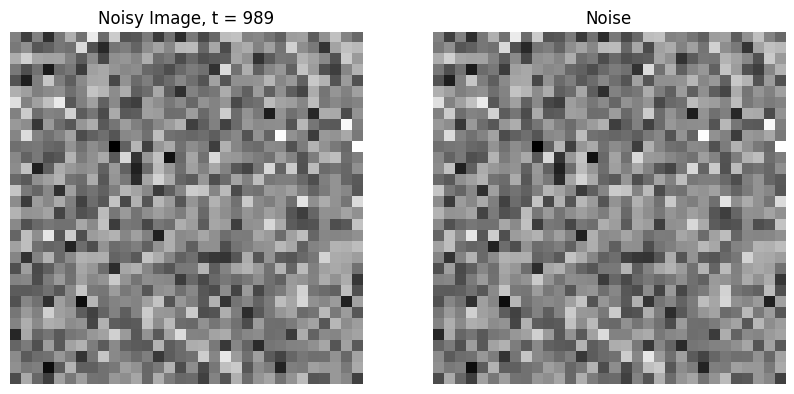

In [75]:
samples = train_dl[0]
print(samples[0].shape)
beta_schedule = torch.linspace(0.0001, 0.02, 1000).to(device)
alpha_bar = get_alpha_bar(beta_schedule)
(noisy_images, t), noise = prepare_batch(samples[0], 1000, alpha_bar)

# noise and the noisy images should have the same shape
# t should be a tensor of shape (batch_size, )
print(noisy_images.shape)
print(t.shape)
print(noise.shape)

def image_noise_plot(noisy_images, t, noise, num_samples=4, predicted_noise = None):
    for i in range(num_samples):
        t_value = t[i].item()  # Get the scalar value from the tensor
        if predicted_noise is not None:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(noisy_images[i].cpu().squeeze().numpy(), cmap='gray')
        ax1.set_title(f'Noisy Image, t = {t_value}')
        ax1.axis('off')
        ax2.imshow(noise[i].cpu().squeeze().numpy(), cmap='gray')
        ax2.set_title('Noise')
        ax2.axis('off')
        if predicted_noise is not None:
            ax3.imshow(predicted_noise[i].cpu().squeeze().detach().numpy(), cmap='gray')
            ax3.set_title('Predicted Noise')
            ax3.axis('off')
        plt.show()

image_noise_plot(noisy_images, t, noise)

In [76]:
print(t)

tensor([634, 659, 528, 989, 204, 615, 782, 123,  75, 850, 388, 762,  35, 963,
        247, 734, 784, 434, 335, 624, 920, 220, 375, 598, 548, 283, 102, 848,
        910, 448, 237, 608, 354, 959,  67, 862, 758, 655, 357, 588, 308, 289,
        120, 253, 173, 739, 787, 251, 998, 265, 423, 271, 967, 879, 157, 890,
        646, 672, 908, 935, 449,  33, 729, 822, 572, 823, 373, 436, 664, 134,
        229, 207, 243, 419, 658, 186, 800, 754, 673, 274,  97, 493, 415, 539,
        688, 674, 450, 835,  19, 902, 521, 848, 817, 928, 347, 396, 700, 402,
         78, 886, 505, 666, 689, 450, 410, 163,  24, 230, 653, 370, 464, 273,
        192, 475, 140, 961, 759, 985, 123, 976, 536, 565, 423, 737, 943, 190,
        664, 814], device='mps:0')


In [77]:
def validate_model(
        model: nn.Module, 
        valid_loader: torch.utils.data.DataLoader, 
        loss_fn: nn.Module, 
        all_valid_loss: list, 
        T: int, 
        alpha_bar: torch.Tensor, 
        using_diffusers: bool = False
        ):
    model.eval()
    valid_loss = []

    with torch.no_grad():
        for batch in valid_loader:
            x, _ = batch
            (noisy_images, t), e = prepare_batch(x, T, alpha_bar=alpha_bar)
            
            if using_diffusers:
                y_pred = model(noisy_images, t).sample # sample for diffusers library components
            else:
                y_pred = model(noisy_images, t)
            
            loss = loss_fn(y_pred, e)
            valid_loss.append(loss.item())
    
    avg_valid_loss = sum(valid_loss) / len(valid_loss)
    all_valid_loss.append(avg_valid_loss)


def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model: nn.Module,
                optim: torch.optim.Optimizer,
                loss_fn: nn.Module,
                train_loader: torch.utils.data.DataLoader,
                valid_loader: torch.utils.data.DataLoader,
                beta_schedule: torch.Tensor,
                epochs: int = 10,
                valid_every: int = 1,
                T: int = 1000,
                scheduler: torch.optim.lr_scheduler._LRScheduler = None,
                using_diffusers: bool = False
                ):

    all_train_loss = []
    all_valid_loss = []

    alpha_bar = get_alpha_bar(beta_schedule)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch} of {epochs}")
        model.train()
        train_loss = []

        
        for batch in train_loader:
            x, _ = batch
            (noisy_images, t), e = prepare_batch(x, T, alpha_bar)
            
            if using_diffusers:
                y_pred = model(noisy_images, t).sample # sample for diffusers library components
            else:
                y_pred = model(noisy_images, t)

            optim.zero_grad()
            loss = loss_fn(y_pred, e)
            loss.backward()
            optim.step()

            if scheduler is not None:
                scheduler.step()

            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        
        
        if epoch % valid_every == 0:
            validate_model(model, valid_loader, loss_fn, all_valid_loss, T, alpha_bar, using_diffusers)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {all_valid_loss[-1]}"
            )

    plot_loss(all_train_loss, all_valid_loss)


The UNet model has 4,374,533 trainable parameters.
Epoch 0 of 30
Epoch 0, Train Loss: 1.1781706919293922, Valid Loss: 0.9094465820095207
Epoch 1 of 30
Epoch 1, Train Loss: 0.9474121840523758, Valid Loss: 0.5937773366517658
Epoch 2 of 30
Epoch 2, Train Loss: 0.6748315792348085, Valid Loss: 0.32563373899158043
Epoch 3 of 30
Epoch 3, Train Loss: 0.44290553926150683, Valid Loss: 0.2008829797747769
Epoch 4 of 30
Epoch 4, Train Loss: 0.3224783441913662, Valid Loss: 0.14982643402829954
Epoch 5 of 30
Epoch 5, Train Loss: 0.254322877189498, Valid Loss: 0.11907171391988103
Epoch 6 of 30
Epoch 6, Train Loss: 0.20874902812529728, Valid Loss: 0.0999945499285867
Epoch 7 of 30
Epoch 7, Train Loss: 0.179994441171699, Valid Loss: 0.08870010568371302
Epoch 8 of 30
Epoch 8, Train Loss: 0.16070571827735983, Valid Loss: 0.08326533455637437
Epoch 9 of 30
Epoch 9, Train Loss: 0.14804285666200398, Valid Loss: 0.07776661811372902
Epoch 10 of 30
Epoch 10, Train Loss: 0.13848409414100749, Valid Loss: 0.074221107

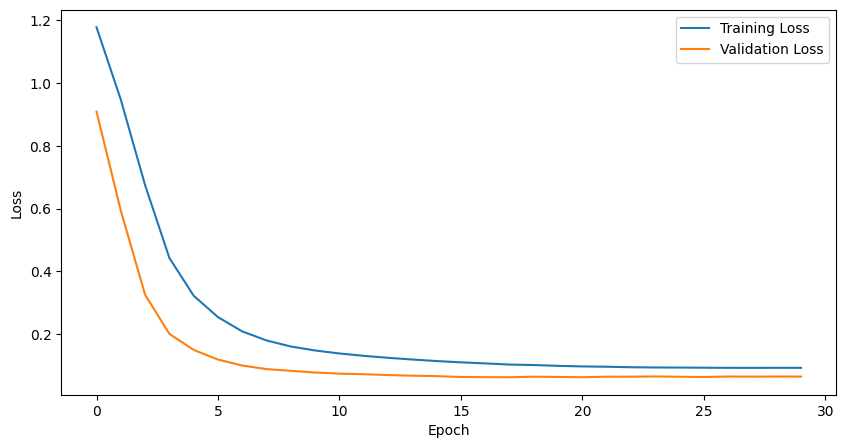

In [79]:
scratch_model = UNet(
    down_filters=[32, 64, 128], 
    in_channels=1, 
    num_layers=2, 
    has_attention=[False, True, False], 
    num_heads=2, 
    diffusion_steps=1000,
).to(device)

num_params = count_parameters(scratch_model)
print(f"The UNet model has {num_params:,} trainable parameters.")

epochs = 30

optim = torch.optim.Adam(scratch_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=2e-5, steps_per_epoch=len(train_dl), epochs=epochs)
loss_fn = nn.MSELoss()

beta_schedule = torch.linspace(0.0001, 0.02, 1000, requires_grad=False).to(device)

train_model(
    model=scratch_model, 
    optim=optim, 
    loss_fn=loss_fn, 
    train_loader=train_dl, 
    valid_loader=valid_dl, 
    beta_schedule=beta_schedule, 
    epochs=epochs, 
    valid_every=1,
    T=1000,
    scheduler=scheduler
)

In [80]:
def sample_images(model, beta_schedule, T, device, num_samples=16, using_diffusers: bool = False):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 1, 32, 32).to(device)
        alpha = 1. - beta_schedule
        alpha_bar = get_alpha_bar(beta_schedule)

        for t in reversed(range(T)):
            time_input = torch.full((num_samples,), t, device=device)
            beta_t = beta_schedule[t]
            sigma_t = beta_t.sqrt()

            alpha_t = alpha[t] if t > 0 else torch.tensor(1.0)
            alpha_bar_t = alpha_bar[t]
            
            alpha_bar_t = alpha_bar[t]
            z = torch.randn_like(x).to(device) if t > 0 else torch.zeros_like(x).to(device)
            
            if using_diffusers:
                model_pred = model(x, time_input).sample
            else:
                model_pred = model(x, time_input)
            
            if t > 0:
                x_t_minus_1 = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * model_pred).clamp(-1, 1) + sigma_t * z
            else:
                x_t_minus_1 = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * model_pred).clamp(-1, 1)
            
            x = x_t_minus_1

    return x

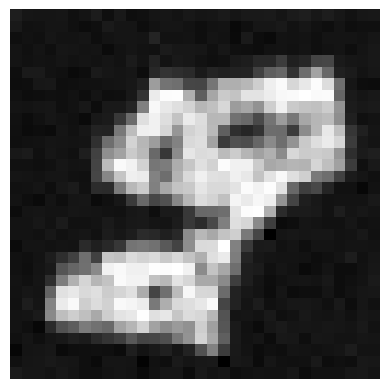

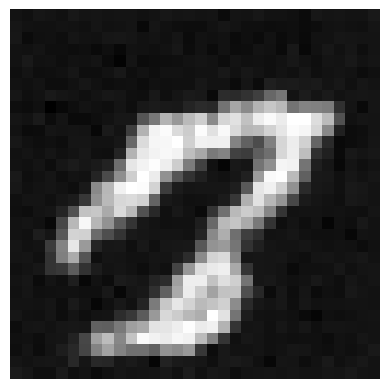

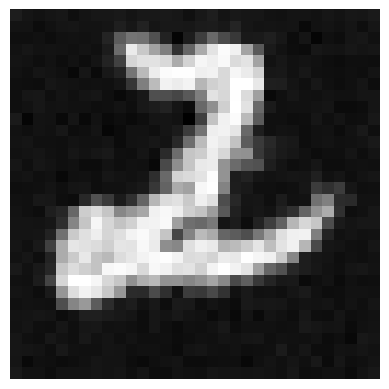

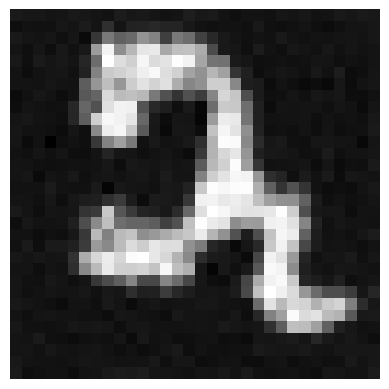

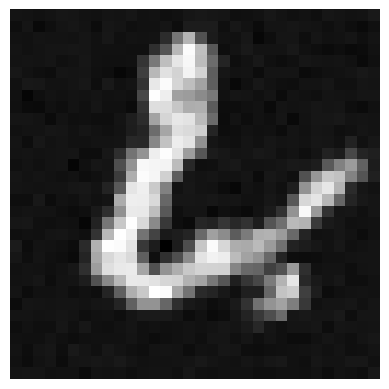

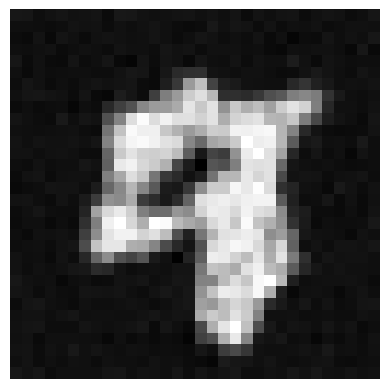

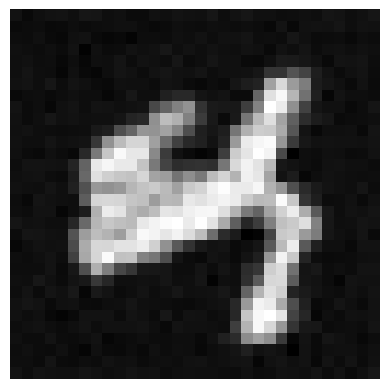

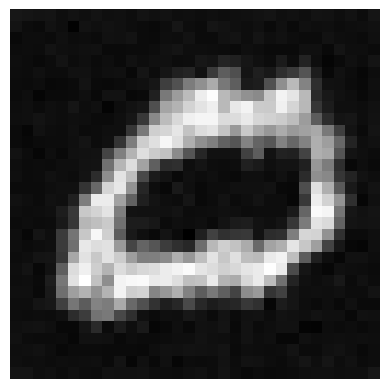

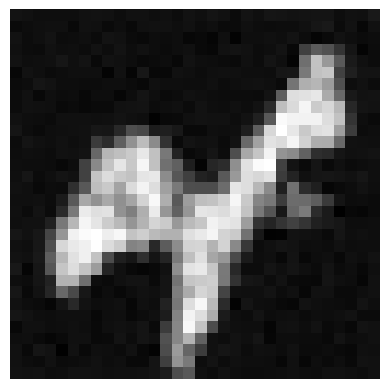

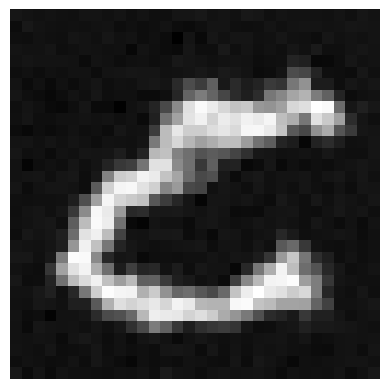

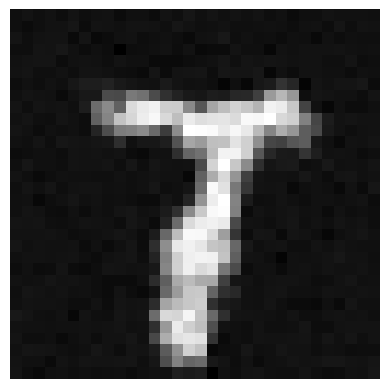

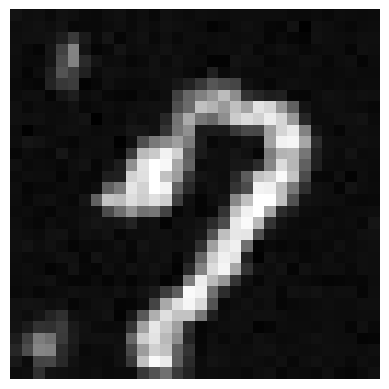

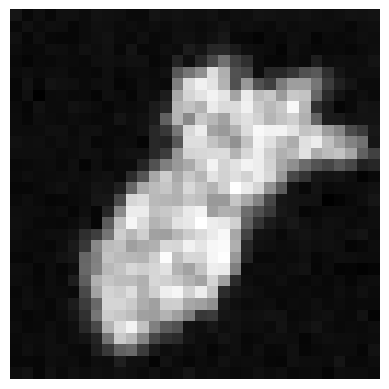

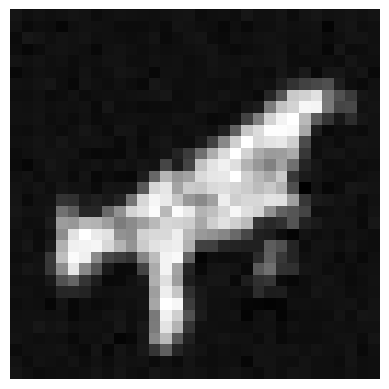

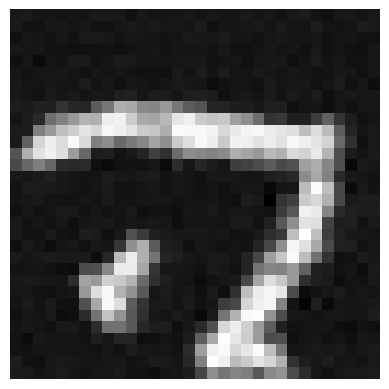

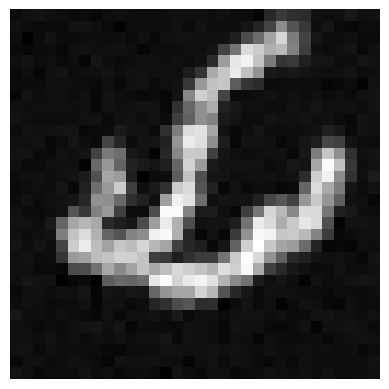

In [81]:
sampled_images = sample_images(scratch_model, beta_schedule, 1000, device, num_samples=16)
sampled_images_cpu = sampled_images.cpu()
for i in range(16):
    show_torch_image(sampled_images_cpu[i])